In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ratings_df = pd.read_csv('data/minified/cleaned_ratings_reduced.csv')
ratings_df.head()

,User-ID,Book-ID,Book-Rating
0,87555,39877,0
1,55490,184467,10
2,139819,184467,0
3,150124,184467,0
4,152016,184467,0


<Axes: >

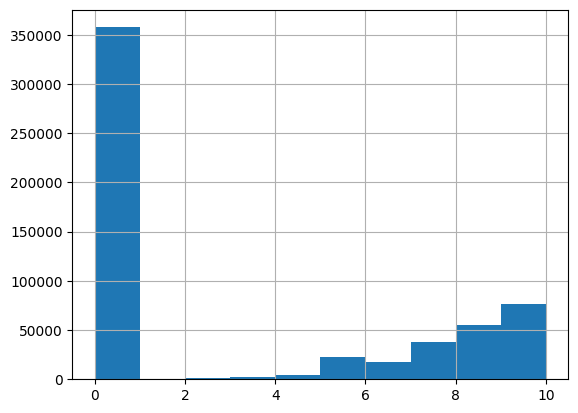

In [3]:
# Look at the ratings column of the ratings table

ratings_df['Book-Rating'].hist(bins=10)

In [4]:
ratings_df["User-ID"].nunique()

68787

We can see that the ratings have been made 1-10

In [5]:
books_df = pd.read_csv('data/minified/cleaned_books_reduced.csv')
books_df.head()

,Book-ID,Book-Title,Book-Author
0,39877,Count of Monte Cristo,A Dumas
1,184467,The Dragon and the Unicorn,A. A. Attanasio
2,231910,When We Were Very Young,A. A. Milne
3,234898,Winnie the Pooh,A. A. Milne
4,191108,The House at Pooh Corner,A. A. Milne


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(books_df['Book-Title'])
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title, result_count=5):
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -1 * result_count)[-1 * result_count:]
    results = books_df.iloc[indices].iloc[::-1]["Book-Title"]
    
    return results

In [7]:
# # Create a pivot table with the ratings table

# ratings_pivot = ratings_df.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
# ratings_pivot.head()

In [7]:
# Remove books with less than 5 ratings

ratings_df_cleaned = ratings_df.groupby('Book-ID').filter(lambda x: len(x) >= 5)
ratings_df_cleaned.head()

,User-ID,Book-ID,Book-Rating
0,87555,39877,0
1,55490,184467,10
2,139819,184467,0
3,150124,184467,0
4,152016,184467,0


In [8]:
len(ratings_df)
# len(ratings_df_cleaned)

576006

In [9]:
ratings_pivot = ratings_df.pivot_table(index='User-ID', columns='Book-ID', values='Book-Rating')
ratings_pivot.head()

Book-ID,2,3,41,93,95,118,155,168,207,218,...,239632,239634,239680,239705,239747,239771,239787,239797,239809,239831
User-ID,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(ratings_pivot)

68787

In [11]:
from surprise import Reader, Dataset, SVD

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(ratings_df_cleaned[['User-ID', 'Book-ID', 'Book-Rating']], reader)


from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=.25)

model = SVD()

model.fit(trainset)

In [12]:
# Reconstruct the ratings table from the SVD model and calculate the RMSE

predictions = model.test(testset)

from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 3.6485


3.648487212407224

In [24]:
# Get the embeddings for the books

book_embeddings = model.qi
book_embeddings

array([[ 0.23779979, -0.20565488,  0.27057889, ...,  0.02019732,
        -0.83934652,  0.233399  ],
       [ 0.36563252,  0.11677591, -0.03499956, ...,  0.09417184,
         0.53846998, -0.16926328],
       [-0.17314338,  0.12266545,  0.03531368, ..., -0.28482381,
         0.26717083, -0.06749316],
       ...,
       [-0.355874  ,  0.02020317,  0.10427912, ...,  0.15658387,
        -0.23116741, -0.16181327],
       [-0.01544338,  0.06673788,  0.22044511, ..., -0.0347848 ,
        -0.34733617,  0.05320305],
       [ 0.04497894,  0.11590241,  0.43676782, ..., -0.10946292,
         0.18098488,  0.02221503]])

In [25]:
len(book_embeddings)

17424